In [1]:
import django_initializer
from telemetry.models import FastLap, Lap
from telemetry.analyzer import Analyzer
from telemetry.influx import Influx

import plotly.express as px
import plotly.io as pio
import scipy

pio.renderers.default = "svg"  # comment this line to use interactive plots
import plotly.graph_objects as go

import pandas as pd

%load_ext autoreload
%autoreload 2

analyzer = Analyzer()
influx = Influx()

2023-05-26 09:14:08,333 DEBUG Influx: Connected to https://telemetry.b4mad.racing/


In [2]:
def lap_fig(df, mode=None, columns=["Throttle", "Brake"], fig=None):
    fig = fig or go.Figure()

    for column in columns:
        color = "red"
        if column == "Throttle":
            color = "green"
        fig.add_scatter(
            x=df["DistanceRoundTrack"],
            y=df[column],
            marker=dict(size=1),
            mode=mode,
            name=column,
            line=dict(color=color),
            showlegend=True,
        )
    return fig


def fig_add_shape(fig, color="black", **kwargs):
    default = dict(
        type="rect",
        xref="x",
        yref="y",
        x0=0,
        y0=0,
        x1=0,
        y1=1,
        line=dict(color=color, width=2, dash="dot"),
    )
    args = {**default, **kwargs}
    fig.add_shape(**args)

In [3]:
# Automobilista 2 - SpaFrancorchamps:Spa_Francorchamps_2022 - Mercedes-Benz CLK LM
# iRacing / richmond / Gen 4 Chevrolet Impala
kwargs = {
    "game__name": "iRacing",
    # "track__name": "fuji nochicane",
    "track__name": "longbeach",
    # "track__name": "nurburgring combined",
    # "track__name": "richmond",
    "car__name": "Ferrari 488 GT3 Evo 2020",
    # "car__name": "Gen 4 Chevrolet Impala",
}
# kwargs = {
#     "game__name": "Automobilista 2",
#     # "track__name": "SpaFrancorchamps:Spa_Francorchamps_2022",
#     "track__name": "Nurburgring_2020:Nordschleife_2020",
#     "car__name": "Porsche 911 RSR GTE",
#     # "car__name": "Mercedes-Benz CLK LM",
# }
lap_id = 0
# lap_id = 43525

laps = []
if lap_id:
    lap = Lap.objects.get(pk=lap_id)
    laps.append(lap)
else:
    fast_laps = FastLap.objects.filter(**kwargs)
    laps.append(fast_laps.first().laps.first())

data_frames = []
for lap in laps:
    print(lap)
    lap_df = influx.telemetry_for_laps([lap], measurement="fast_laps", bucket="fast_laps")[0]
    data_frames.append(
        {
            "lap": lap,
            "df": lap_df,
        }
    )

2023-05-26 09:14:08,480 INFO Processing iRacing - longbeach - Ferrari 488 GT3 Evo 2020
2023-05-26 09:14:08,480 INFO   track.id 53 car.id 9
2023-05-26 09:14:08,480 INFO   session 1685011715 lap.id 88946 number 1
2023-05-26 09:14:08,481 INFO   length 3139 time 80.8779 valid True
2023-05-26 09:14:08,481 INFO   start 2023-05-25 12:50:17.318098+00:00 end 2023-05-25 12:51:38.200889+00:00


1: 12:50:17 - 12:51:38 80.8779s 3139m valid: True


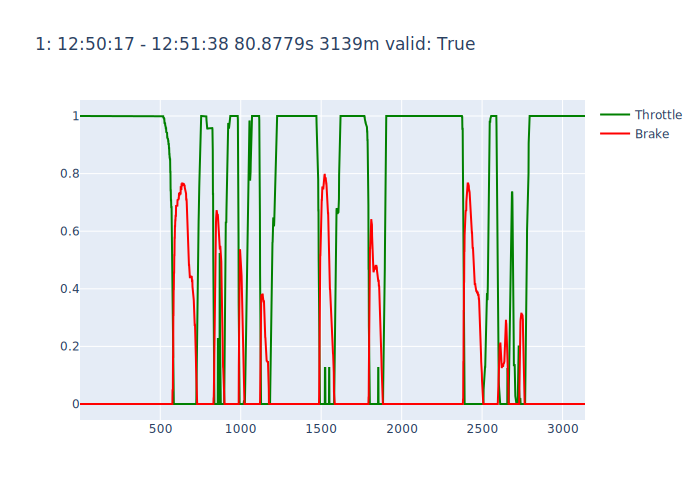

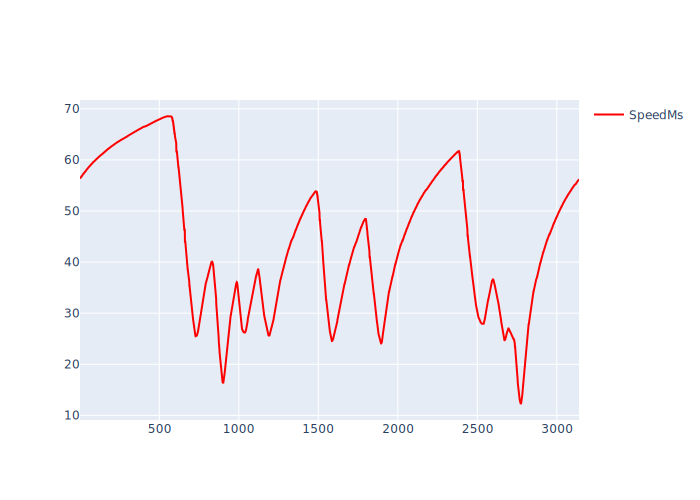

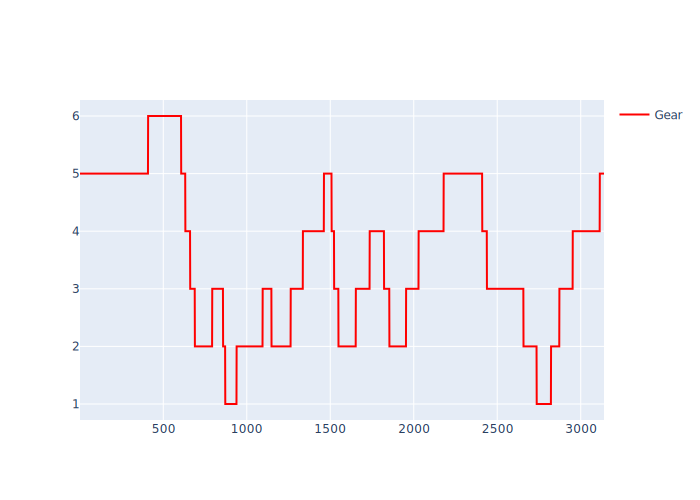

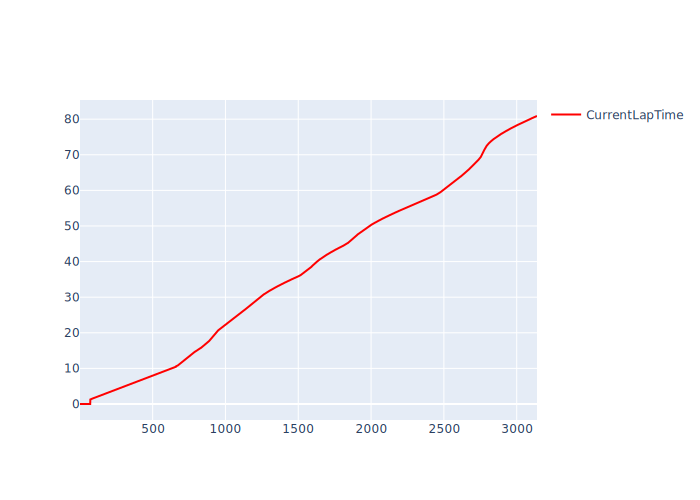

In [4]:
for data_frame in data_frames:
    lap = data_frame["lap"]
    lap_df = data_frame["df"]
    # display(lap_df.head())
    columns = ["Brake", "SpeedMs", "Throttle", "Gear", "CurrentLapTime"]
    lap_df = analyzer.resample(lap_df, columns=columns)
    data_frame["df"] = lap_df

    # window_length = 9  # should be odd and >= polynomial_order + 2
    # polynomial_order = 2
    # lap_df['Throttle'] = scipy.signal.savgol_filter(lap_df['Throttle'], window_length, polynomial_order)

    fig = lap_fig(lap_df)
    fig.update_layout(title=dict(text=f"{lap}"))
    fig.show()

    fig = lap_fig(lap_df, columns=["SpeedMs"])
    fig.show()
    fig = lap_fig(lap_df, columns=["Gear"])
    fig.show()
    fig = lap_fig(lap_df, columns=["CurrentLapTime"])
    fig.show()
    fig.update_layout(title=dict(text=f"{lap}"))

In [5]:
track_df = data_frames[0]["df"].copy()

In [6]:
threshold = track_df["Throttle"].max() * 0.98
display(threshold)
sectors = analyzer.split_sectors(track_df, threshold=threshold, min_length=50)
# for i in range(len(sectors)):
#     display(sectors[i].head())
#     fig = lap_fig(sectors[i])
#     fig.update_layout(title=dict(text=f"{i}"))
#     fig.show()
len(sectors)

0.98

8

In [7]:
sector_start_end = analyzer.extract_sector_start_end(sectors, min_length=50)
print(len(sector_start_end))
sector_start_end

8


[{'start': 516, 'end': 777, 'length': 261},
 {'start': 778, 'end': 972, 'length': 194},
 {'start': 973, 'end': 1105, 'length': 132},
 {'start': 1106, 'end': 1460, 'length': 354},
 {'start': 1461, 'end': 1764, 'length': 303},
 {'start': 1765, 'end': 2366, 'length': 601},
 {'start': 2367, 'end': 2578, 'length': 211},
 {'start': 2579, 'end': 515, 'length': 1075}]

In [8]:
# for i in (0, -1):
#     sector = analyzer.section_df(track_df, sector_start_end[i]['start'], sector_start_end[i]['end'])
#     fig = lap_fig(sector, mode="markers")
#     fig.update_layout(title=dict(text=f"{i}"))
#     fig.show()

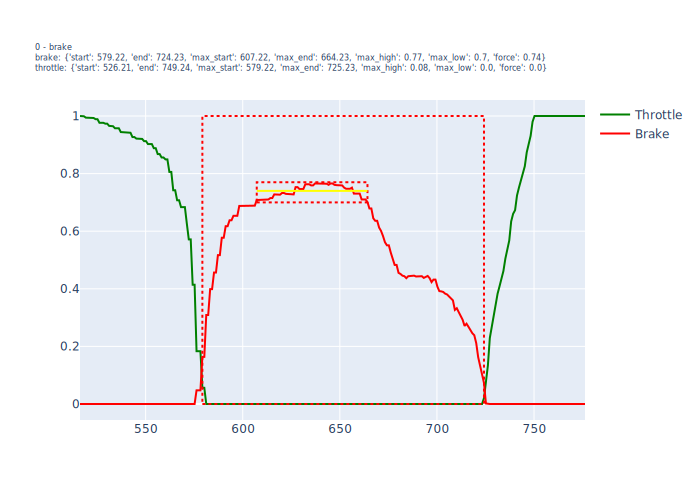

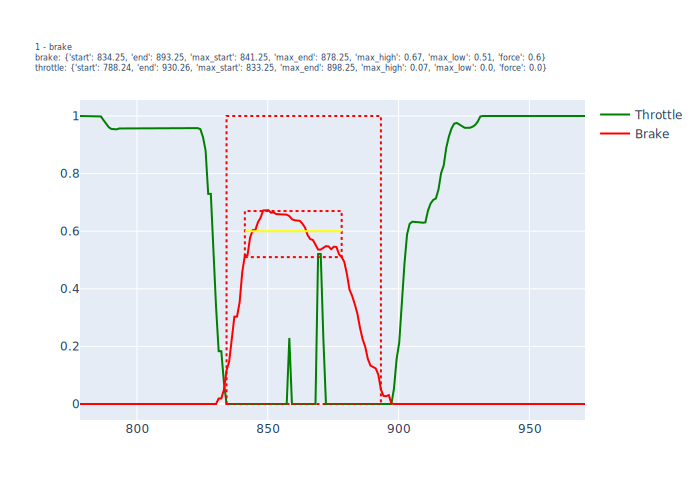

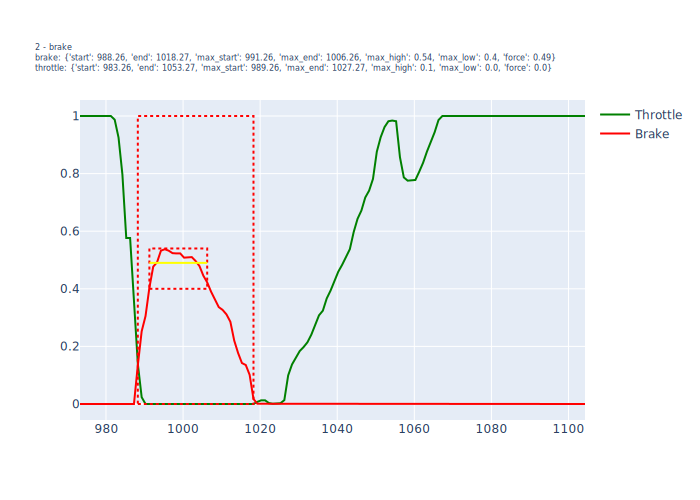

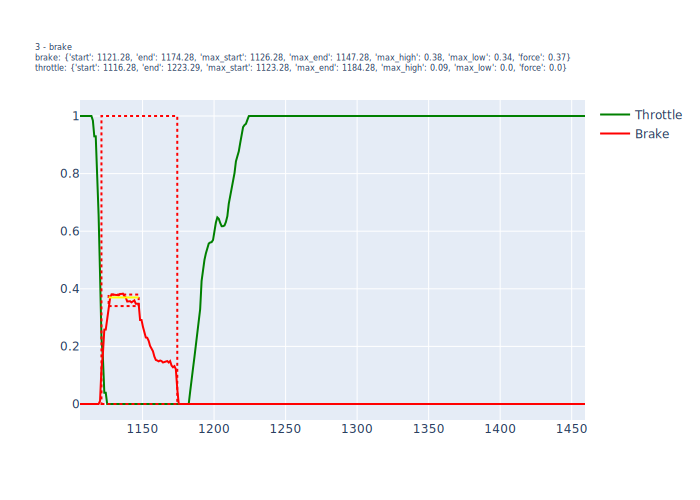

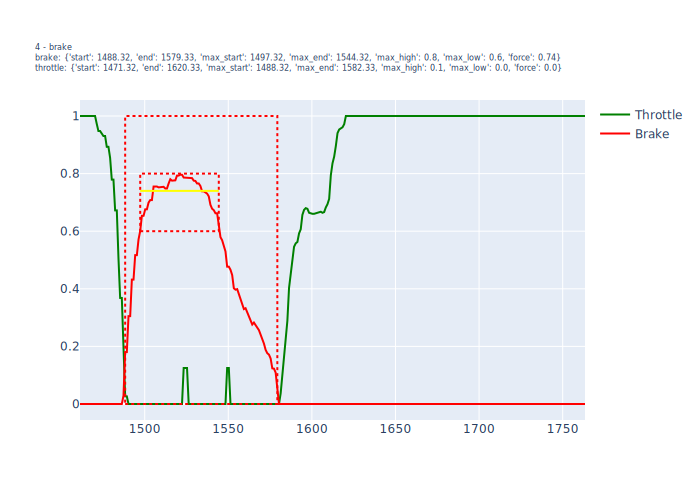

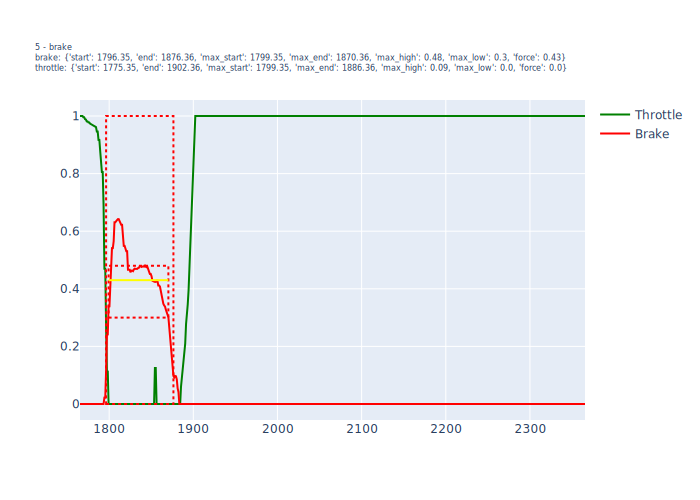

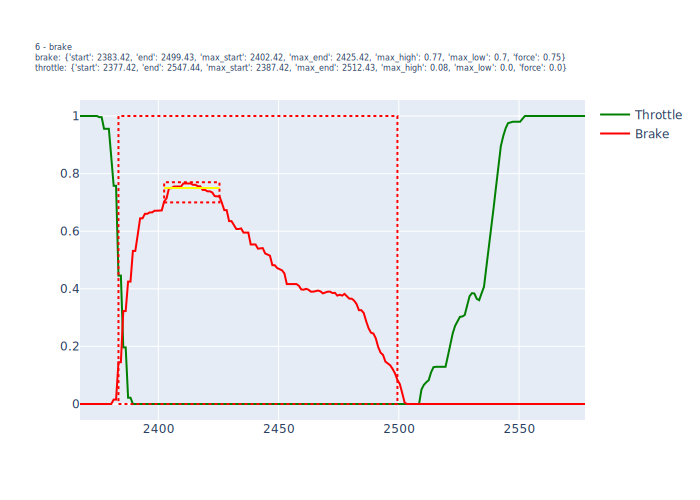

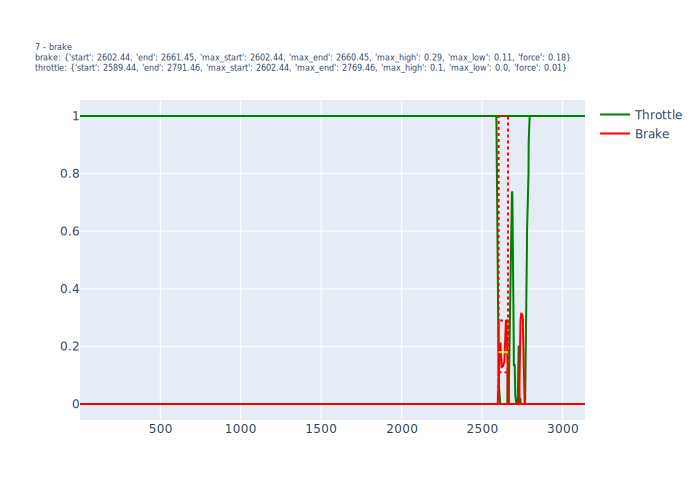

In [9]:
brake_feature_args = {
    "brake_threshold": 0.1,
}
throttle_features_args = {
    # "throttle_threshold": 0.98,
}
sector_dfs = []


def fig_add_features(fig, features, color="red"):
    fig_add_shape(fig, x0=features["start"], x1=features["end"], color=color)
    fig_add_shape(
        fig,
        x0=features["max_start"],
        y0=features["max_low"],
        x1=features["max_end"],
        y1=features["max_high"],
        color=color,
    )
    fig_add_shape(
        fig,
        type="line",
        x0=features["max_start"],
        y0=features["force"],
        x1=features["max_end"],
        y1=features["force"],
        line=dict(color="yellow", width=2),
    )


for i in range(len(sector_start_end)):
    sector = analyzer.section_df(track_df, sector_start_end[i]["start"], sector_start_end[i]["end"])
    sector_dfs.append(sector)
    fig = lap_fig(sector)

    throttle_or_brake = analyzer.sector_type(sector)
    # if throttle_or_brake == "brake":
    #     continue
    # if i != 2:
    #     continue
    # fig.show()
    title = f"{i} - {throttle_or_brake}<br>"

    brake_features = analyzer.brake_features(sector, **brake_feature_args)
    title += f"brake: {brake_features}<br>"
    if brake_features and throttle_or_brake == "brake":
        fig_add_features(fig, brake_features)

    throttle_features = analyzer.throttle_features(sector, **throttle_features_args)
    if throttle_features and throttle_or_brake == "throttle":
        fig_add_features(fig, throttle_features, color="green")
    title += f"throttle: {throttle_features}"

    fig.update_layout(title=dict(text=title, font=dict(size=8)))

    fig.show()

monotonic


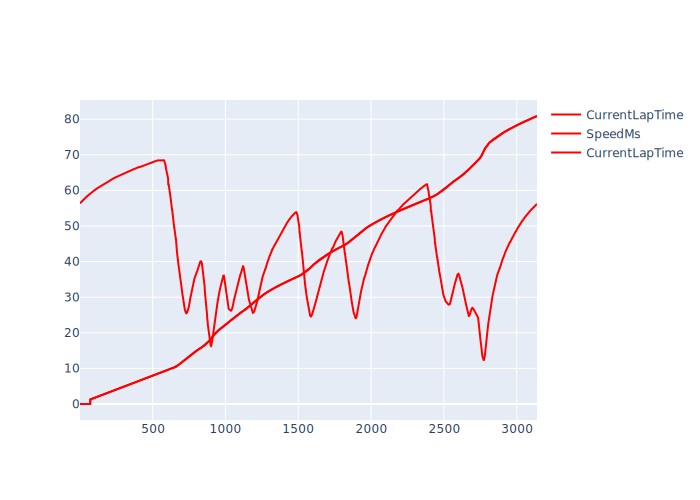

,DistanceRoundTrack,CurrentLapTime,SpeedMs
0,1.2,0.020,56.346035
1,2.2,0.000,56.428333
2,3.2,0.000,56.428333
3,4.2,0.000,56.497520
4,5.2,0.000,56.497520
...,...,...,...
3134,3135.5,80.821,56.046070
3135,3136.5,80.821,56.046070
3136,3137.5,80.854,56.136406
3137,3138.5,80.854,56.136406


In [12]:
monotonic = track_df["CurrentLapTime"].is_monotonic_increasing
if monotonic:
    print("monotonic")
    lookup = analyzer.distance_speed_lookup_table_non_lin(track_df)
else:
    print("not monotonic")
    lookup = analyzer.distance_speed_lookup_table_lin(track_df)

# lookup = analyzer.resample(lookup, columns=["SpeedMs", "CurrentLapTime"])
fig = lap_fig(lookup, columns=["CurrentLapTime", "SpeedMs"])
lap_fig(track_df, columns=["CurrentLapTime"], fig=fig)
fig.show()

lookup
# track_df